# **Import Important Libraries**

In [39]:
from google.colab import drive                                        # For import dataset
import pandas as pd                                                   # For loading dataset
import matplotlib.pyplot as plt                                       # For data vizualization
import seaborn as sns                                                 # For displaying confusion matrix
import string                                                         # For removing punctuations
import spacy                                                          # For POS tagging to count nouns and verbs
from spacy.lang.en import English, stop_words                         # For text preprocessing and removing stopwords
from sklearn.preprocessing import LabelEncoder                        # For encoding target value
from sklearn.model_selection import train_test_split                  # For splitting dataset
from sklearn.naive_bayes import MultinomialNB                         # For Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression                   # For Logistic Regression
from sklearn.svm import SVC                                           # For Support Vector Machines
from sklearn.neighbors import KNeighborsClassifier                    # For K-Nearest Neighbours Classifier
from sklearn.ensemble import RandomForestClassifier                   # For Random Forest Classifier
from sklearn.tree import DecisionTreeClassifier                       # For Decision Tree Classifier
from sklearn.metrics import confusion_matrix, classification_report   # For confusion matrix and classification report
import pickle                                                         # For storing and loading the model

# **Load Dataset**

In [40]:
# Load data from drive
drive.mount('/content/drive')
data = pd.read_csv('drive/My Drive/spam.csv',encoding='latin-1')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [41]:
#drop unnecessary columns
data = data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# **Data Analysis**

In [42]:
# See information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


There are no null values

([<matplotlib.patches.Wedge at 0x7d6e8c0a3790>,
 [Text(-1.0038714981945518, 0.4497132587689916, 'ham'),
  Text(1.1863935638950363, -0.5314793613569908, 'spam')],
 [Text(-0.5475662717424827, 0.24529814114672266, '86.6%'),
  Text(0.7300883470123298, -0.32706422237353283, '13.4%')])

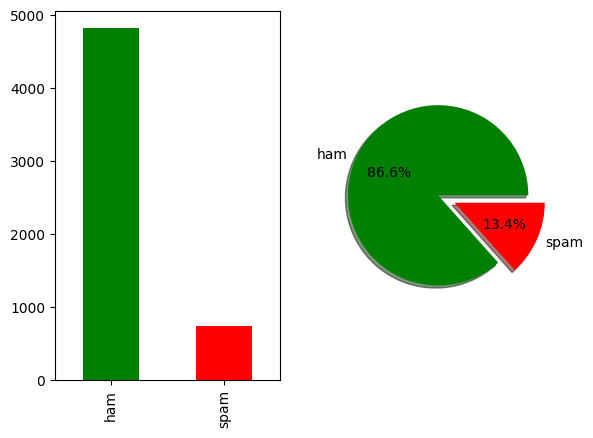

In [43]:
# Vizualize dataset
plt.subplot(121)
data['v1'].value_counts().plot(kind='bar',color=['g','r'])
plt.subplot(122)
plt.pie(data['v1'].value_counts(),colors=['g','r'],labels=['ham','spam'],autopct='%1.1f%%',shadow=True,explode=(0,0.2))

Our dataset contains 13.4% spam messages and 86.6% ham messages

# **Text Preprocessing**

In [44]:
nlp = English()

# Function to preprocess
def cleaned(text):

  # Convert to lowercase
  cleaned = text.lower()

  # Remove punctuations
  cleaned = "".join(char for char in cleaned if char not in string.punctuation)

  # Tokenization
  my_doc = nlp(cleaned)
  token_list = []
  for token in my_doc:
    token_list.append(token.text)

  # Remove stop-words
  filtered_sentence = []
  for word in token_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
      filtered_sentence.append(word)

  # Preprocessed message
  cleaned = " ".join(filtered_sentence)

  return cleaned


In [45]:
# Preprocess messages
data['cleaned'] = data['v2'].apply(cleaned)
data.head()

,v1,v2,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives


# **Feature Extraction**

In [46]:
data['word_count'] = data['v2'].apply(lambda x: len(x.split()))                                        # Word count of original message
data['word_count_cleaned'] = data['cleaned'].apply(lambda x: len(x.split()))                           # Word count of cleaned message
data['char_count'] = data['cleaned'].apply(lambda x: len(x))                                           # Character count of cleaned message including spaces
data['char_count_no_space'] = data['cleaned'].apply(lambda x: len(x.replace(" ","")))                  # Character count of cleaned message excluding spaces
data['num_count'] = data['cleaned'].apply(lambda x: len([tok for tok in x.split() if tok.isdigit()]))  # Digit count of cleaned message

In [47]:
data.head()

,v1,v2,cleaned,word_count,word_count_cleaned,char_count,char_count_no_space,num_count
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,20,15,79,65,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,6,6,23,18,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,28,22,131,110,3
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,11,6,19,14,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives,13,6,27,22,0


In [48]:
nlp = spacy.load('en_core_web_sm')

# Dictionary of POS tags of nouns and verbs
pos_dic = { 'noun':['NN','NNS','NNP','NNPS'], 'verb':['VB','VBD','VBG','VBN','VBZ','VBP']}

# Function to count nouns and verbs
def pos_count(text,pos_fam):

  doc = nlp(text)

  tags = []
  for word in doc:
    tags.append(word.tag_)

  count = 0

  for tag in tags:
    if tag in pos_dic[pos_fam]:
      count+=1

  return count


In [49]:
# Count number of nouns and verbs in all messages
data['noun_count'] = data['cleaned'].apply(lambda x: pos_count(x,'noun'))
data['verb_count'] = data['cleaned'].apply(lambda x: pos_count(x,'verb'))

In [50]:
data.head()

,v1,v2,cleaned,word_count,word_count_cleaned,char_count,char_count_no_space,num_count,noun_count,verb_count
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,20,15,79,65,0,10,2
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,6,6,23,18,0,3,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,28,22,131,110,3,12,2
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,11,6,19,14,0,6,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives,13,6,27,22,0,1,2


# **Dataset Preparation**

In [51]:
# Convert categorical target to numerical
le = LabelEncoder()
data['v1'] = le.fit_transform(data['v1'])
data.head()

,v1,v2,cleaned,word_count,word_count_cleaned,char_count,char_count_no_space,num_count,noun_count,verb_count
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,20,15,79,65,0,10,2
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,6,6,23,18,0,3,1
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,28,22,131,110,3,12,2
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,11,6,19,14,0,6,0
4,0,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives,13,6,27,22,0,1,2


In [52]:
# Prepare features
features = data.iloc[:,3:]
target = data['v1'].values

In [53]:
# Splitting dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(features, target, random_state=20, stratify=target)

# **Train classifiers**

In [54]:
# Function to display confusion matrix and classification report
def plot_report(model):

  # Training and testing predictions
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  plt.figure(figsize=(15,6))

  labels = ['ham','spam']

  # Confusion matrix
  plt.subplot(121)
  plt.title("Train Confusion Matrix")
  sns.heatmap(confusion_matrix(Y_train, pred_train),annot=True)
  plt.subplot(122)
  plt.title("Test Confusion Matrix")
  sns.heatmap(confusion_matrix(Y_test, pred_test),annot=True)

  # Classification report
  print('\nTrain Classification Report:')
  print(classification_report(Y_train, pred_train,target_names=labels))
  print('\nTest Classification Report:')
  print(classification_report(Y_test, pred_test,target_names=labels))

## **Naive Bayes Classifier**


Train Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.97      0.97      3619
        spam       0.79      0.75      0.77       560

    accuracy                           0.94      4179
   macro avg       0.88      0.86      0.87      4179
weighted avg       0.94      0.94      0.94      4179


Test Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96      1206
        spam       0.75      0.77      0.76       187

    accuracy                           0.93      1393
   macro avg       0.86      0.86      0.86      1393
weighted avg       0.93      0.93      0.93      1393



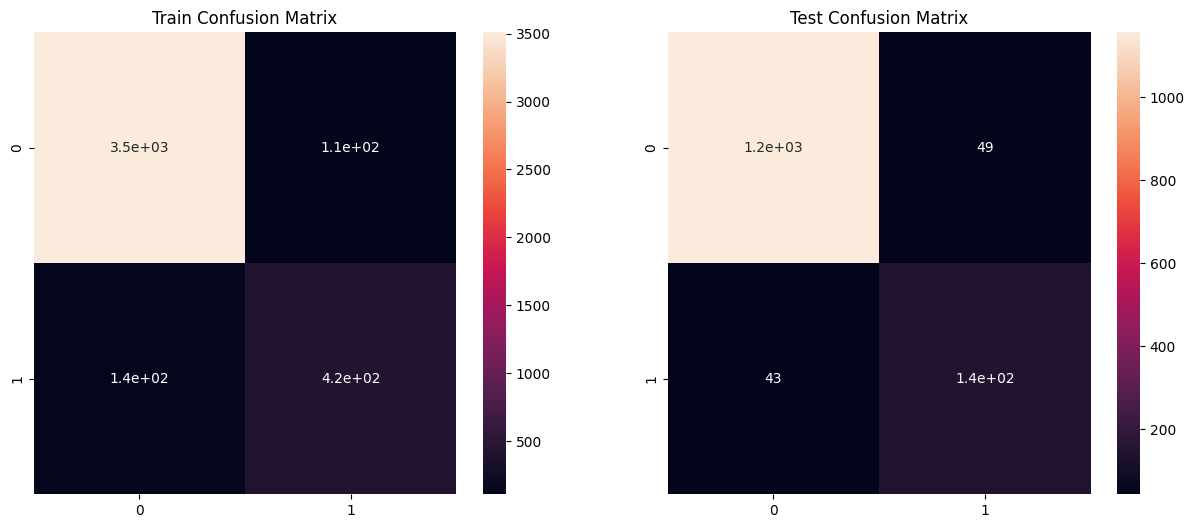

In [55]:
model_nb = MultinomialNB()
model_nb.fit(X_train,Y_train)
plot_report(model_nb)

## **Logistic Regression**


Train Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.98      0.98      3619
        spam       0.89      0.78      0.83       560

    accuracy                           0.96      4179
   macro avg       0.93      0.88      0.90      4179
weighted avg       0.96      0.96      0.96      4179


Test Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.98      0.97      1206
        spam       0.83      0.78      0.80       187

    accuracy                           0.95      1393
   macro avg       0.90      0.88      0.89      1393
weighted avg       0.95      0.95      0.95      1393



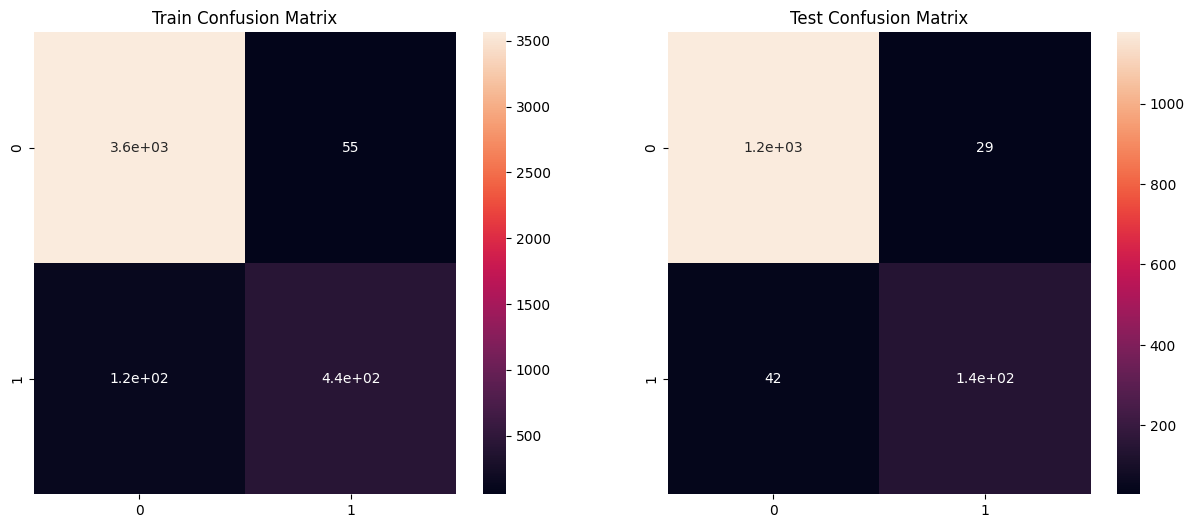

In [56]:
model_lr = LogisticRegression(solver="liblinear")
model_lr.fit(X_train,Y_train)
plot_report(model_lr)

## **Support Vector Machine**


Train Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.97      0.97      3619
        spam       0.80      0.73      0.76       560

    accuracy                           0.94      4179
   macro avg       0.88      0.85      0.86      4179
weighted avg       0.94      0.94      0.94      4179


Test Classification Report:
              precision    recall  f1-score   support

         ham       0.95      0.97      0.96      1206
        spam       0.79      0.70      0.74       187

    accuracy                           0.93      1393
   macro avg       0.87      0.83      0.85      1393
weighted avg       0.93      0.93      0.93      1393



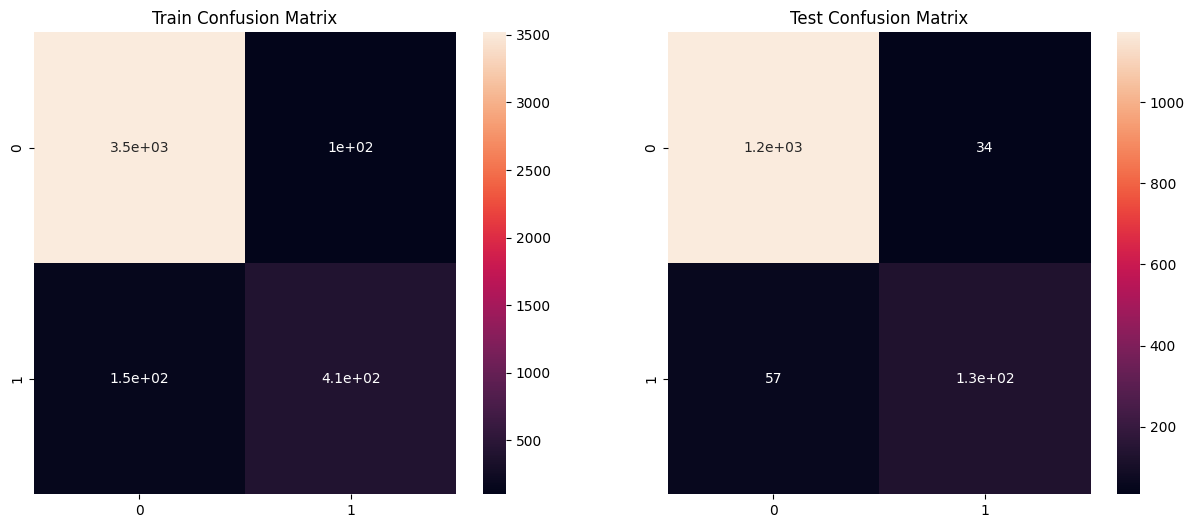

In [57]:
model_svm = SVC(kernel="rbf")
model_svm.fit(X_train,Y_train)
plot_report(model_svm)

## **K-Nearest Neighbours Classifier**


Train Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      3619
        spam       0.87      0.85      0.86       560

    accuracy                           0.96      4179
   macro avg       0.92      0.91      0.92      4179
weighted avg       0.96      0.96      0.96      4179


Test Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.97      0.97      1206
        spam       0.79      0.80      0.79       187

    accuracy                           0.94      1393
   macro avg       0.88      0.88      0.88      1393
weighted avg       0.94      0.94      0.94      1393



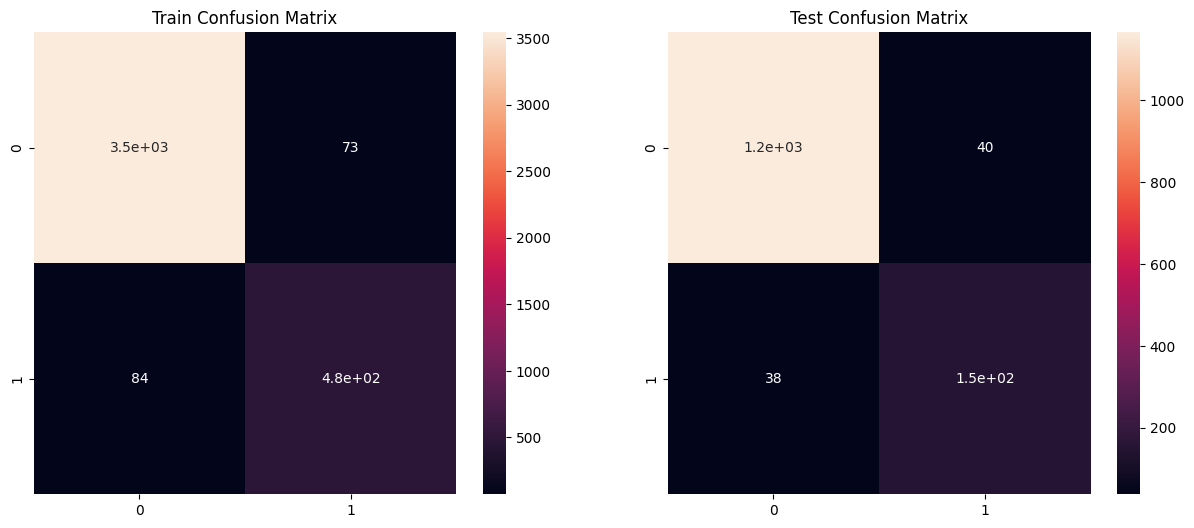

In [58]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train,Y_train)
plot_report(model_knn)

## **Random Forest Classifier**


Train Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3619
        spam       1.00      1.00      1.00       560

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179


Test Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1206
        spam       0.90      0.83      0.86       187

    accuracy                           0.96      1393
   macro avg       0.94      0.91      0.92      1393
weighted avg       0.96      0.96      0.96      1393



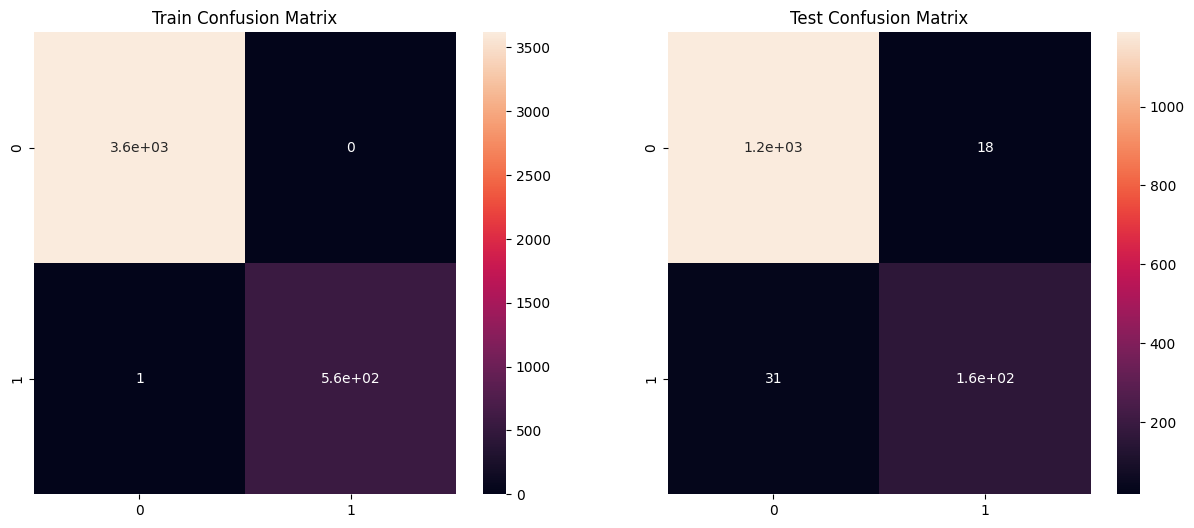

In [59]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train,Y_train)
plot_report(model_rfc)

## **Decision Tree Classifier**


Train Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3619
        spam       1.00      1.00      1.00       560

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179


Test Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.96      0.97      1206
        spam       0.75      0.83      0.79       187

    accuracy                           0.94      1393
   macro avg       0.86      0.90      0.88      1393
weighted avg       0.94      0.94      0.94      1393



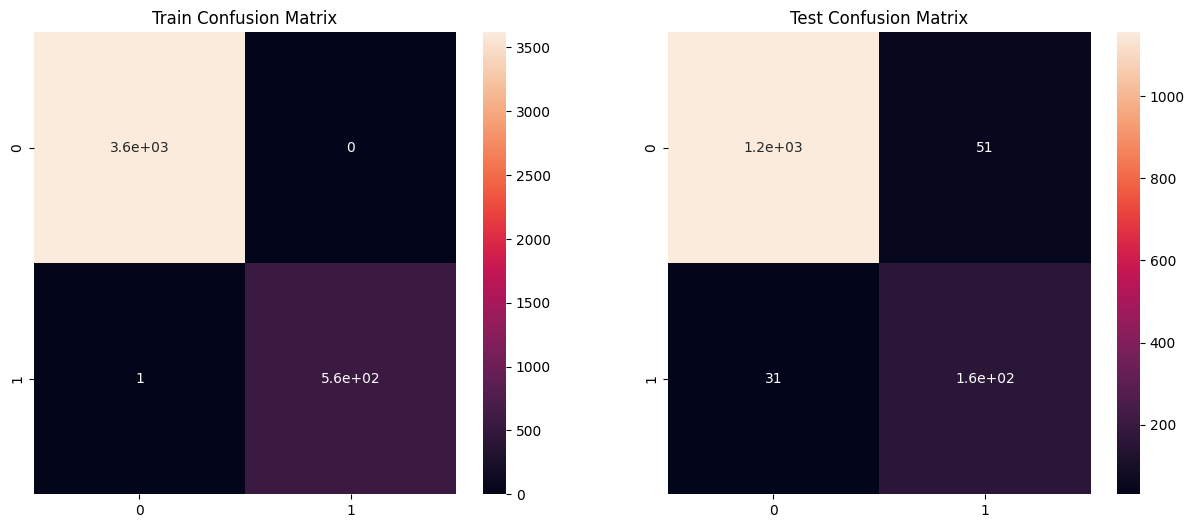

In [60]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,Y_train)
plot_report(model_dt)

## **Store the best model**

In [61]:
pickle.dump(model_rfc,open("classifier.pkl","wb"))

# **Final Application**

In [62]:
# Read given message
msg = input("Enter message : ")

# Preprocess the message
cln_msg = cleaned(msg)

# Extract features
feat = [[len(msg.split()), len(cln_msg.split()), len(cln_msg), len(cln_msg.replace(" ","")), len([tok for tok in cln_msg.split() if tok.isdigit()]), pos_count(cln_msg,'noun'), pos_count(cln_msg,'verb')]]

# Load model
model = pickle.load(open("classifier.pkl","rb"))

# Predict ham or spam
pred = model.predict(feat)

# Display prediction
if pred==0:
  print("Prediction    : ham")
else:
  print("Prediction    : spam")

Enter message : This is the 2nd time we have tried to contact u. U have won the å£1450 prize to claim just call 09053750005 b4 310303. T&Cs/stop SMS 08718725756. 140ppm
Prediction    : spam


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
